# UI Component Classification Model 
### _Using the Wireframes Provided along with the [ReDraw Dataset](https://zenodo.org/record/2530277)_

Here, we build a CNN-based model to classify the detected UI components using Transfer Learning (with base model as the [`cnn-wireframes-only.h5`](https://drive.google.com/file/d/1eUqku9yAZ8MfxCS5FxlsagZmcP1PN-JU/view?usp=sharing) that was created & used in [UIED](https://github.com/MulongXie/UIED))


**Dataset**: [Snipped components](https://github.com/tezansahu/smart_ui_tf20/tree/main/dataset/snipped) from the [Wireframes](https://drive.google.com/file/d/1_HWKHk1_r4PLrORTrDjtCZOigB9rQpHL/view?usp=sharing) provided by the organizers, along with a variety of components from the [ReDraw Dataset](https://zenodo.org/record/2530277)

## Preliminaries

In [1]:
import os
os.chdir("/content/drive/MyDrive/TechFest 2020 Smart UI")

In [2]:
import matplotlib
matplotlib.use("Agg")

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
import numpy as np
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

## CNN Model Architecture

In [3]:
# Load the base model
model = load_model("cnn-wireframes-only.h5")

In [4]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8388

In [6]:
CLASSES = 13
HEIGHT = 64
WIDTH = 64
CHANNELS = 3

In [7]:
for i in range(6):
    model.layers[i].trainable = False

ll = model.layers[5].output
ll = Dense(256, activation="relu")(ll)
ll = Dropout(0.2)(ll)
ll = Dense(128, activation="relu")(ll)
ll = Dropout(0.2)(ll)
ll = Dense(CLASSES, activation="softmax")(ll)

In [8]:
new_model = Model(inputs=model.input,outputs=ll)

In [9]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               167774

## Dataset Preparation

In [10]:
# Image preprocessing for robustness
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=(0.9,1),
    height_shift_range=(-0.05, 0.05),
    width_shift_range=(-0.05, 0.05),
)

In [15]:
BATCH_SIZE = 10

print("[INFO] loading images...")
train_data_dir = "./dataset/snipped_wireframe_redraw"     # directory of training data

training_set = train_datagen.flow_from_directory(train_data_dir, 
                                                 target_size=(WIDTH, HEIGHT),
                                                 batch_size=BATCH_SIZE, 
                                                 class_mode='categorical')

[INFO] loading images...
Found 1202 images belonging to 13 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data_dir = "./dataset/snipped_wireframe_redraw"       # directory of test data
test_set = test_datagen.flow_from_directory(test_data_dir, 
                                            target_size=(WIDTH, HEIGHT),
                                            batch_size=BATCH_SIZE, 
                                            class_mode='categorical',
                                            shuffle=False)

Found 1202 images belonging to 13 classes.


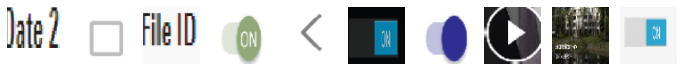

In [13]:
# Plot some images form the augmented results

x_batch, y_batch = next(training_set)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    # img = (img - np.min(img))/(np.max(img) - np.min(img))
    plt.subplot(5, 10, k+1)
    # im = Image.open(img).convert('RGB')
    plt.imshow(np.asarray(img)[:, :, ])
    plt.axis('off')

## Model Training

In [14]:
new_model.compile(
    loss="categorical_crossentropy", 
    optimizer = Adam(lr=0.001), 
    metrics=["accuracy"]
)

In [16]:
print("[INFO] training model...")

EPOCHS = 25

history = new_model.fit(
    training_set,
    epochs=EPOCHS,
    steps_per_epoch=training_set.samples//BATCH_SIZE,
    validation_data=test_set,
    validation_steps=test_set.samples//BATCH_SIZE
)

[INFO] training model...
Epoch 1/25
120/120 [==============================] - 750s 6s/step - loss: 1.7076 - accuracy: 0.4591 - val_loss: 0.7984 - val_accuracy: 0.7658
Epoch 2/25
120/120 [==============================] - 6s 54ms/step - loss: 0.5620 - accuracy: 0.8256 - val_loss: 0.6015 - val_accuracy: 0.8125
Epoch 3/25
120/120 [==============================] - 6s 53ms/step - loss: 0.3955 - accuracy: 0.8823 - val_loss: 0.4521 - val_accuracy: 0.8650
Epoch 4/25
120/120 [==============================] - 6s 53ms/step - loss: 0.2899 - accuracy: 0.9170 - val_loss: 0.4628 - val_accuracy: 0.8725
Epoch 5/25
120/120 [==============================] - 6s 53ms/step - loss: 0.2026 - accuracy: 0.9447 - val_loss: 0.3954 - val_accuracy: 0.8833
Epoch 6/25
120/120 [==============================] - 6s 54ms/step - loss: 0.2352 - accuracy: 0.9309 - val_loss: 0.6051 - val_accuracy: 0.8708
Epoch 7/25
120/120 [==============================] - 6s 54ms/step - loss: 0.1475 - accuracy: 0.9706 - val_loss: 0.37

In [17]:
# Save the model
print("[Info] serializing network...")
new_model.save("cnn-generalized.h5")

[Info] serializing network...


In [18]:
# Function to plot the accuracy & losses over epochs of training

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b*--', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'rD:', label="Validation Accuracy")
    plt.legend()
    plt.title('Training accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b*--', label="Training Loss")
    plt.plot(epochs, val_loss, 'rD:', label="Validation Loss")
    plt.legend()
    plt.title('Training loss')
    
    plt.savefig("component_classification_training.png", bbox_inches="tight")
    plt.show()

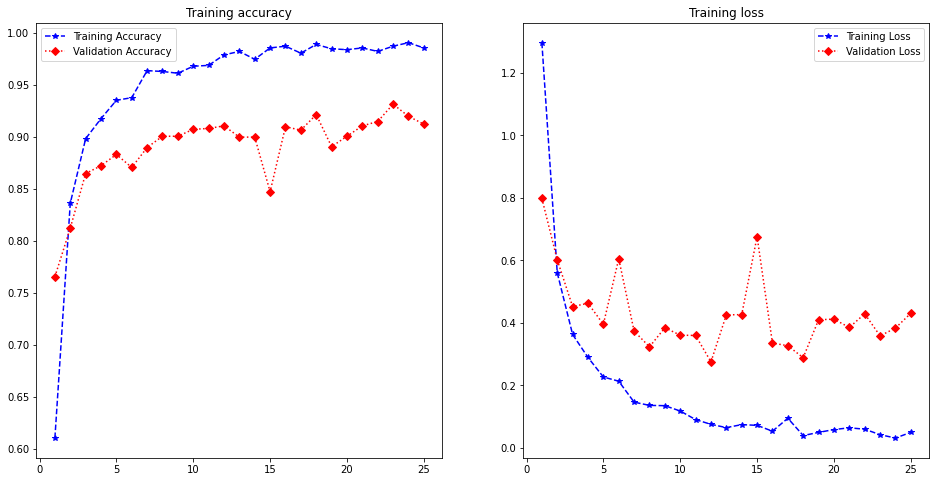

In [19]:
plot_training(history)

## Model Evaluation

In [ ]:
new_model = load_model("cnn-generalized.h5")

In [20]:
pred = new_model.predict(
    test_set, 
    steps=test_set.samples//BATCH_SIZE + 1,
    verbose=1
)
pred = np.argmax(pred, axis=1)

121/121 [==============================] - 2s 20ms/step


In [21]:
class_labels = [x[0][x[0].find("/", 10)+1:] for x in os.walk("dataset/snipped_wireframe_redraw")][1:]
class_labels.sort()

Confusion Matrix


Text(0.5, 122.09375, 'Predicted label')

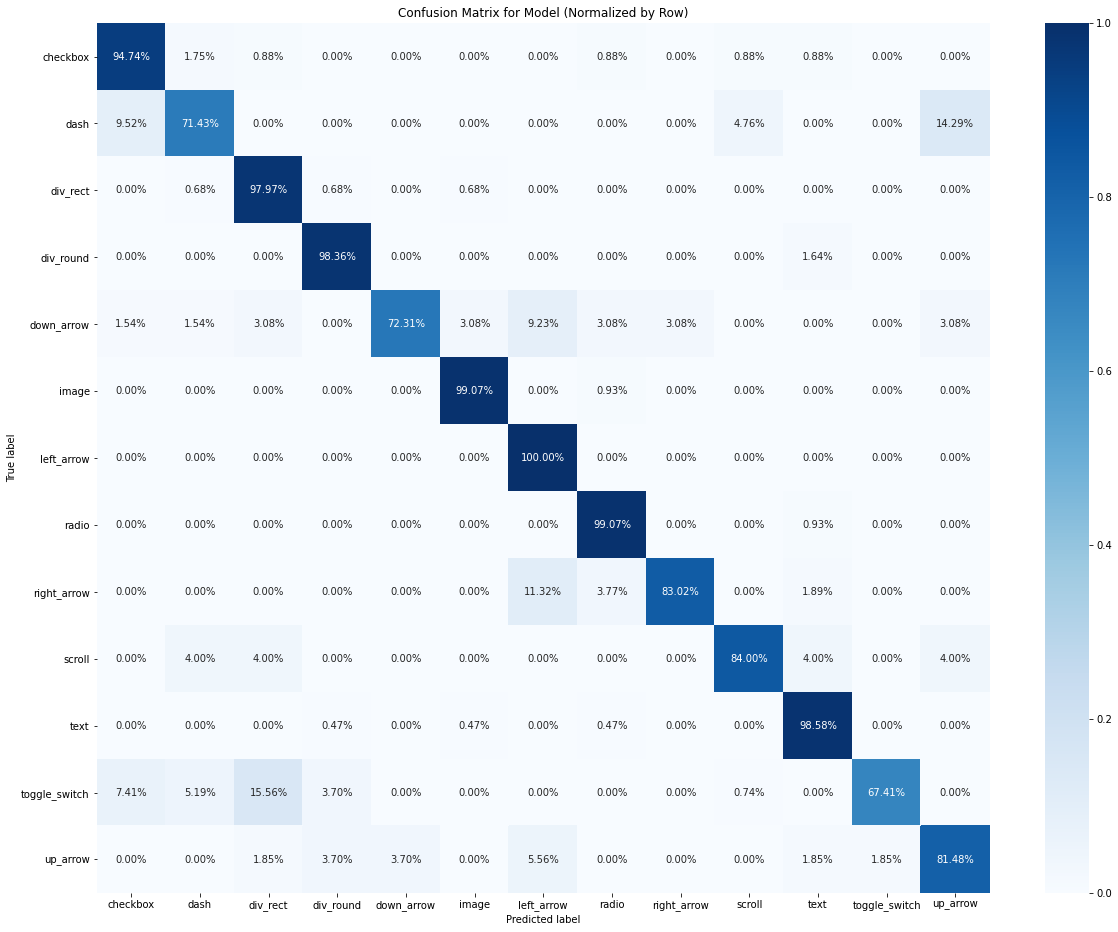

In [22]:
import sklearn

print('Confusion Matrix')
cf = confusion_matrix(test_set.classes[test_set.index_array], pred)

plt.figure(figsize=(20, 16))
normalized_cf = sklearn.preprocessing.normalize(cf, norm="l1")
sns.heatmap(normalized_cf, annot=True, fmt=".2%", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title("Confusion Matrix for Model (Normalized by Row)")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [23]:
print('\nClassification Report')
print(classification_report(test_set.classes[test_set.index_array], pred, target_names=class_labels))


Classification Report
               precision    recall  f1-score   support

     checkbox       0.89      0.95      0.92       114
         dash       0.56      0.71      0.63        21
     div_rect       0.85      0.98      0.91       148
    div_round       0.87      0.98      0.92        61
   down_arrow       0.96      0.72      0.82        65
        image       0.96      0.99      0.98       107
   left_arrow       0.87      1.00      0.93       100
        radio       0.94      0.99      0.96       108
  right_arrow       0.96      0.83      0.89        53
       scroll       0.88      0.84      0.86        25
         text       0.97      0.99      0.98       211
toggle_switch       0.99      0.67      0.80       135
     up_arrow       0.88      0.81      0.85        54

     accuracy                           0.91      1202
    macro avg       0.89      0.88      0.88      1202
 weighted avg       0.92      0.91      0.91      1202



In [ ]:
def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]
